# Классификация белков на семейства по их аминокислотным последовательностям

Используемые данные:

- pdb_data_seq.csv и pdb_data_no_dups.csv: https://www.kaggle.com/shahir/protein-data-set  
    (Датасет собран с RCSB PDB. Используется лишь как тренировочный набор данных)
- ly6upar.csv: известные и подтвержденные трехпетельные белки. Собран из данных Михаила Мышкина и всех результатов поиска на ncbi proteins по запросу Ly6/uPAR (https://www.ncbi.nlm.nih.gov/protein/?term=ly6%2Fupar)
- arubens_seq.csv и aplanci_seq.csv: протеом, полученный от Михаила Мышкина. Таргетный набор данных

модель взята здесь: https://www.kaggle.com/abharg16/predicting-protein-classification

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, log_loss, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
# from math import e as expon
import sklearn.metrics as metrics
from Utilities import *


from sklearn.naive_bayes import MultinomialNB

# df_seq = pd.read_csv('input/pdb_data_seq.csv', index_col=0)  # Данные с kaggle
# df_char = pd.read_csv('input/pdb_data_no_dups.csv', index_col=0)  # Данные с kaggle

model_f = pd.read_csv('input/cl_input.csv', index_col=0)  # обработанный датасет из pdb
df_aru = pd.read_csv('input/arubens_seq.csv', index_col=0)  # Протеом A. rubens
df_apl = pd.read_csv('input/aplanci_seq.csv', index_col=0)  # протеом A. planci
df_ly6 = pd.read_csv('input/ly6upar.csv', index_col=0)  # Известные трехпетельные белки
df_ly6['classification'] = 'Ly6/uPAR'  # дополнительный столбец под нужды модели

In [2]:
print('%d количество белков в аблице, имеющих и название семейства и последовательность' %model_f.shape[0])

87799 количество белков в аблице, имеющих и название семейства и последовательность


In [3]:
# Количество белков различных семейств
counts = model_f.classification.value_counts()
print('Количество белков семейства Ly6/uPAR в датасете равно %d' %df_ly6.classification.value_counts()['Ly6/uPAR'])
print()

# количество белков различных семейств, представленных приблизительно в том же количестве, что и Ly6/uPAR
counts = counts[(counts > 200) & (counts < 300)]
print(counts)

Количество белков семейства Ly6/uPAR в датасете равно 227

BIOSYNTHETIC PROTEIN           279
MOTOR PROTEIN                  262
FLUORESCENT PROTEIN            260
VIRAL PROTEIN/IMMUNE SYSTEM    258
TRANSCRIPTION REGULATOR        246
CYTOKINE                       227
CONTRACTILE PROTEIN            216
PEPTIDE BINDING PROTEIN        215
HORMONE                        212
REPLICATION                    205
HYDROLASE INHIBITOR            203
IMMUNOGLOBULIN                 202
Name: classification, dtype: int64


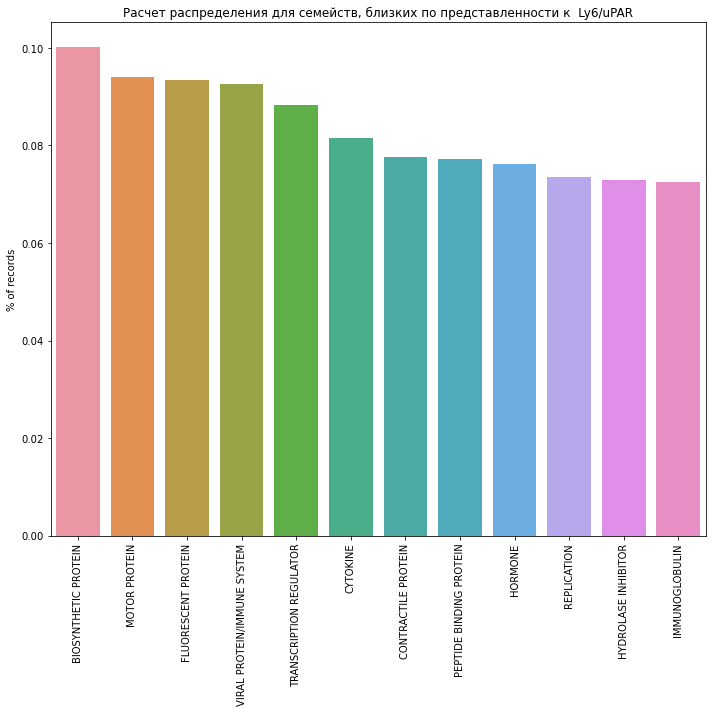

In [4]:
# Рисуем распределение
fig , ax = plt.subplots()
fig.set_size_inches(10, 10)
g = sns.barplot(x=counts.index, y=counts.div(counts.sum()))
g.set_xticklabels(counts.index, rotation=90)
plt.title('Расчет распределения для семейств, близких по представленности к  Ly6/uPAR')
plt.ylabel('% of records')
plt.tight_layout()
plt.show()

In [5]:
# Получить названия семейств, близких по представленности к  Ly6/uPAR
types = counts.index.tolist()

# Фильтрация датасета
data = model_f[model_f.classification.isin(types)].copy()
print(types)
print()
print('%d is the number of records in the final filtered dataset' %data.shape[0])

['BIOSYNTHETIC PROTEIN', 'MOTOR PROTEIN', 'FLUORESCENT PROTEIN', 'VIRAL PROTEIN/IMMUNE SYSTEM', 'TRANSCRIPTION REGULATOR', 'CYTOKINE', 'CONTRACTILE PROTEIN', 'PEPTIDE BINDING PROTEIN', 'HORMONE', 'REPLICATION', 'HYDROLASE INHIBITOR', 'IMMUNOGLOBULIN']

2785 is the number of records in the final filtered dataset


In [6]:
X_train, X_test, y_train, y_test = train_test(data, df_ly6)  # функция из utilities
types += ['Ly6/uPAR']
y_test.shape, X_train.shape

((1208,), (1804,))

### Исследование моделей

In [7]:
# Тест по случайным величинам
precision_r, recall_r, f1_score_r = [], [], []

res = y_test.copy()
for i in range(100):
    np.random.shuffle(res)
    tmp = precision_recall_fscore_support(y_pred=res, y_true=y_test, labels=['Ly6/uPAR'])
    precision_r += [tmp[0][0]]
    recall_r += [tmp[1][0]]
    f1_score_r += [tmp[2][0]]

print('random precison = ', np.mean(precision_r))
print('random recall = ', np.mean(recall_r))
print('random f1 score = ', np.mean(f1_score_r))

random precison =  0.07659574468085106
random recall =  0.07659574468085106
random f1 score =  0.07659574468085106


In [8]:
# GridSearch по значениям nram для векторизатора

precision, recall, accuracy, f1_score, indexes, log_loss_ = [], [], [], [], [], []
for i in range(2, 15):
    for j in range(i, 15):

        NB_pipeline = Pipeline(steps=[
            ('tokenizer', CountVectorizer(analyzer = 'char_wb', ngram_range = (i,j))),
            ('model', MultinomialNB())
        ])
        
        NB_pipeline.fit(X_train, y_train)

        NB_pred = NB_pipeline.predict(X_test)

        accr = accuracy_score(NB_pred, y_test)
        f1 = precision_recall_fscore_support(y_pred=NB_pred, y_true=y_test, labels=['Ly6/uPAR'])
        loss = log_loss(y_pred=label_binarize(NB_pred, classes=['Ly6/uPAR']),
                        y_true=label_binarize(y_test, classes=['Ly6/uPAR']))
        print(i, j)
        print('accuracy NB = ', accr)
        print('logistic Loss for NB', loss)
        
        precision.append(f1[0][0])
        recall.append(f1[1][0])
        f1_score.append(f1[2][0])
        accuracy.append(accr)
        log_loss_.append(loss)
        indexes.append((i, j))

2 2
accuracy NB =  0.5447019867549668
logistic Loss for NB 1.7441242893802495
2 3
accuracy NB =  0.6183774834437086
logistic Loss for NB 1.3724275258737513
2 4
accuracy NB =  0.597682119205298
logistic Loss for NB 0.9721278074407427
2 5
accuracy NB =  0.5786423841059603
logistic Loss for NB 1.1436740498123343
2 6
accuracy NB =  0.5753311258278145
logistic Loss for NB 1.2580382113933959
2 7
accuracy NB =  0.5745033112582781
logistic Loss for NB 1.286629251788661
2 8
accuracy NB =  0.5736754966887417
logistic Loss for NB 1.2866285898702587
2 9
accuracy NB =  0.5769867549668874
logistic Loss for NB 1.2580362256381885
2 10
accuracy NB =  0.5802980132450332
logistic Loss for NB 1.2866279279518562
2 11
accuracy NB =  0.5827814569536424
logistic Loss for NB 1.2866279279518562
2 12
accuracy NB =  0.5844370860927153
logistic Loss for NB 1.2580362256381885
2 13
accuracy NB =  0.5836092715231788
logistic Loss for NB 1.2866279279518562
2 14
accuracy NB =  0.5827814569536424
logistic Loss for NB 1.

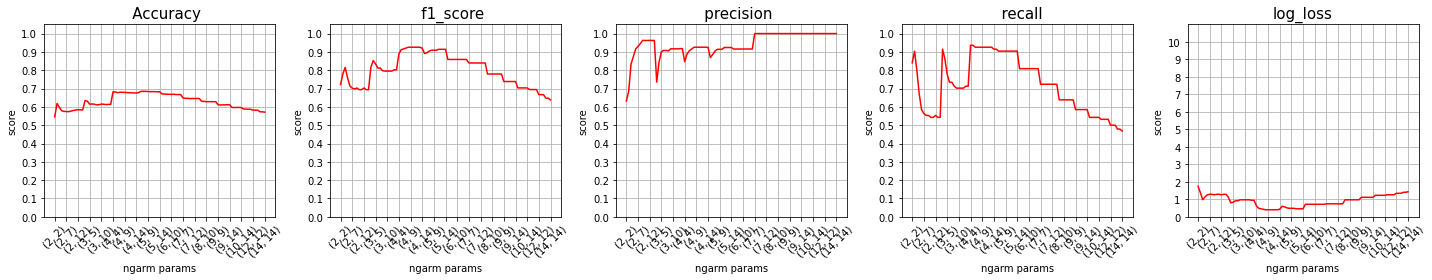

In [9]:
# Графики метрик для моделей по ngram парметру

fig, ax = plt.subplots(1, 5, figsize=(20, 4), tight_layout=True)

metrs = [accuracy, f1_score, precision, recall, log_loss_]
labels = ['   Accuracy', '   f1_score', '   precision', '  recall', 'log_loss']
for i, y, label, index in zip([0, 1, 2, 3, 4], metrs, labels, [indexes] * 5):
    ax_plotter(ax, i, y, label=label, indexes=index)
    ax[i].grid()
plt.tight_layout()
plt.show()

In [10]:
i, j = indexes[f1_score.index(max(f1_score))]
print(i, j)

4 8


In [11]:
# Итоговая модель NB
NB_pipeline = Pipeline(steps=[
            ('tokenizer', CountVectorizer(analyzer = 'char_wb', ngram_range = (i, j))),
            ('model', MultinomialNB())
            ])
NB_pipeline.fit(X_train, y_train)

NB_pred = NB_pipeline.predict(X_test)
accr = accuracy_score(NB_pred, y_test)
f1 = precision_recall_fscore_support(y_pred=NB_pred, y_true=y_test, labels=['Ly6/uPAR'])
print('accuracy = ', accr)
print(f'precison = {f1[0][0]}\nrecall = {f1[1][0]}\n')

accuracy =  0.679635761589404
precison = 0.925531914893617
recall = 0.925531914893617



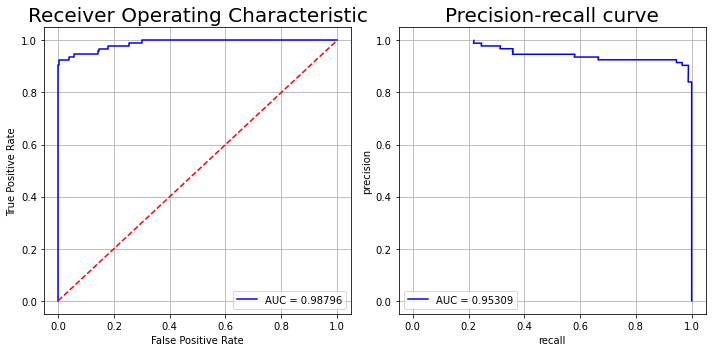

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# находим индекс класса трехпетельных для вытаскивания метрик по нему метрик
x = 0
for i in enumerate(NB_pipeline.classes_):
    x = i[0] if i[1] == 'Ly6/uPAR' else x

# calculate the fpr and tpr for all thresholds of the classification
probs = NB_pipeline.predict_proba(X_test)
preds = probs[:, x]
y_true = label_binarize(y_test, classes=['Ly6/uPAR'])

fpr, tpr, threshold = metrics.roc_curve(y_true, preds)
roc_auc = metrics.roc_auc_score(y_true, preds, average='weighted')

# Receiver Operating Characteristic
ax[0].set_title('Receiver Operating Characteristic', size=20)
ax[0].plot(fpr, tpr, 'b', label = 'AUC = %.5f' % roc_auc)
ax[0].legend(loc = 'lower right')
ax[0].plot([0, 1], [0, 1],'r--')
ax[0].set_xlim([-0.05, 1.05])
ax[0].set_ylim([-0.05, 1.05])
ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')
ax[0].grid()

# Precision-recall curve
rec, pre, threshold = metrics.precision_recall_curve(y_true, preds)
pr_rec = metrics.average_precision_score(y_true, preds, average='weighted')
ax[1].plot(rec, pre, 'b', label='AUC = %.5f' % pr_rec)
ax[1].legend(loc = 'lower left')
ax[1].set_title('Precision-recall curve', size=20)
ax[1].set_ylabel('precision')
ax[1].set_xlabel('recall')
ax[1].set_xlim([-0.05, 1.05])
ax[1].set_ylim([-0.05, 1.05])
ax[1].grid()
plt.tight_layout()
plt.show()

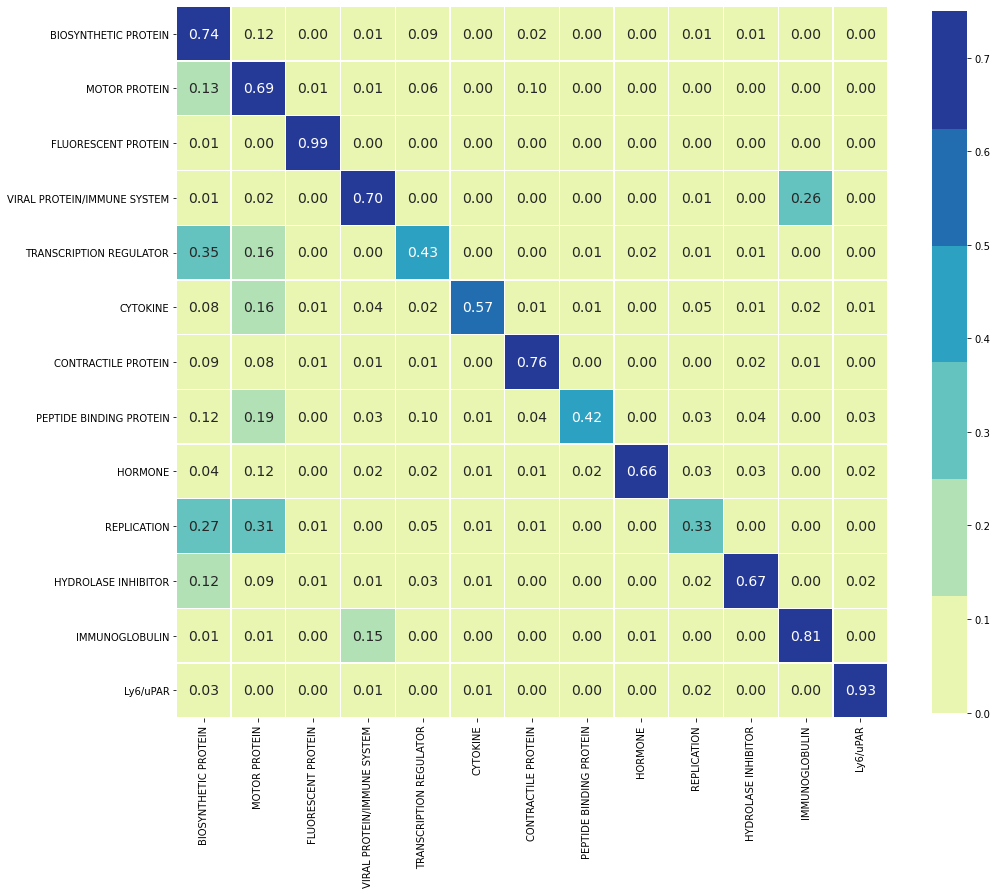

In [13]:
# Построение матрицы ошибок
conf_mat_m = confusion_matrix(y_true=y_test, y_pred=NB_pred, labels=types, normalize='true')

# Строим HeatMap
fig , ax = plt.subplots(1, 1, figsize=(15, 15), tight_layout=True)

m = sns.heatmap(conf_mat_m, annot=True, fmt='.2f', linewidths=.3,
                annot_kws={"size": 14},
                square=True, robust=True, 
                cmap=sns.color_palette("YlGnBu"), cbar_kws={'shrink': 0.7}
                )
m.set_xticklabels(types, rotation=90)
m.set_yticklabels(types, rotation=360)
plt.show()

In [14]:
# Вывод метрик отчета классификации
print(classification_report(y_test, NB_pred))

                             precision    recall  f1-score   support

       BIOSYNTHETIC PROTEIN       0.41      0.74      0.52       107
        CONTRACTILE PROTEIN       0.77      0.76      0.76        86
                   CYTOKINE       0.91      0.57      0.70        92
        FLUORESCENT PROTEIN       0.96      0.99      0.97       110
                    HORMONE       0.95      0.66      0.78        90
        HYDROLASE INHIBITOR       0.84      0.67      0.75        88
             IMMUNOGLOBULIN       0.72      0.81      0.76        85
                   Ly6/uPAR       0.93      0.93      0.93        94
              MOTOR PROTEIN       0.40      0.69      0.51       108
    PEPTIDE BINDING PROTEIN       0.89      0.42      0.57        77
                REPLICATION       0.60      0.33      0.43        78
    TRANSCRIPTION REGULATOR       0.54      0.43      0.48        99
VIRAL PROTEIN/IMMUNE SYSTEM       0.72      0.70      0.71        94

                   accuracy     

In [15]:
# Feauture importance

x = 0
for i in enumerate(NB_pipeline.classes_):
    x = i[0] if i[1] == 'Ly6/uPAR' else x
print('top 20 highest values')
print()
top = show_most_informative_features(NB_pipeline, 20, x)
for (coef_2, fn_2) in top:
    print(f"{coef_2}   '{fn_2.upper()}'")


top 20 highest values

-11.340028499721205   'ALGG'
-11.340028499721205   'ALGGH'
-11.340028499721205   'CYTC'
-11.340028499721205   'LCNS'
-11.340028499721205   'LGGH'
-11.340028499721205   'LLLA'
-11.271035628234253   'EQPSGE'
-11.271035628234253   'QPSGE'
-11.206497107096682   'DRCN'
-11.206497107096682   'EQPSG'
-11.206497107096682   'GEQPS'
-11.206497107096682   'PSGE'
-11.206497107096682   'QPSG'
-11.145872485280247   'SGEQP'
-11.0887140714403   'NLCN'
-11.034646850170024   'EQPS'
-10.983353555782474   'GEQP'
-10.843591613407314   'SGEQ'
-10.683248963332135   'LLLL'
-10.513349926536737   'DLCN'


/home/alexmakh/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
